In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook'])
from scipy import sparse
import torch
from torch import lobpcg
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Create a meshgrid of $x$ and $y$ coordinates

In [8]:
N = 400
X, Y = np.mgrid[0:1:N*1j,0:1:N*1j]

Eigenstates of the Schrodinger equation satisfy $H\psi = E\psi$ where $H$ is the Hamiltonian operator, and $E$ and $\psi$ represent the eigenvalues/eigenstates. The Hamiltonian Operator in 2D is

$$H = -\frac{1}{2m}\left( \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}\right) + V(x,y)$$

If we discretize $\psi$ into a vector (spacing $\Delta x$), the equation $H\psi = E\psi$ can be arranged and rewritten in 2 dimensions as

$$\left[-\frac{1}{2}(D \oplus D) + m\Delta x^2 V \right] \psi = \left(m \Delta x^2 E\right) \psi$$

where

* $\psi$ is a vector of length $N^2$ where $N$ is the number of discretized points in $x$ and $y$
* $D$ is an $N \times N$ matrix with -2 on the main diagonal and 1 on the two neighbouring diagonals.
* $D \oplus D$: the kronecker sum of $D$ with itself so that the derivative matrix is effectively converted to operate on a "2D" vector
* $V$ is a diagonal $N^2 \times N^2$ matrix with each entry on the diagonal representative of the potential at that particular coordinate.

 Firstly, we define our potential in units of $m \Delta x^2$; in other words `get_potential` actually returns $m\Delta x^2 V$

In [9]:
def get_potential(x, y):
    return np.exp(-(x-0.3)**2/(2*0.1**2))*np.exp(-(y-0.3)**2/(2*0.1**2))
V = get_potential(X,Y)

Now we construct

$$- \frac{1}{2} D \oplus D + m\Delta x^2 V $$

Let $T=- \frac{1}{2} D \oplus D$ and $U = m\Delta x^2 V$

In [11]:
V.reshape(N**2).shape

(160000,)

In [12]:
diag = np.ones([N])
diags = np.array([diag, -2*diag, diag])
D = sparse.spdiags(diags, np.array([-1,0,1]), N, N)
T = -1/2 * sparse.kronsum(D,D)
U = sparse.diags(V.reshape(N**2), (0))
H = T+U

Convert to sparse pytorch tensor

In [13]:
H = H.tocoo()
H = torch.sparse_coo_tensor(indices=torch.tensor([H.row, H.col]), values=torch.tensor(H.data), size=H.shape).to(device)

C:\Users\prath\AppData\Local\Temp\ipykernel_3532\2973072149.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  H = torch.sparse_coo_tensor(indices=torch.tensor([H.row, H.col]), values=torch.tensor(H.data), size=H.shape).to(device)


Compute the eigenvalues and eigenvectors:

In [15]:
eigenvalues, eigenvectors = lobpcg(H, k=10, largest=False)

In [16]:
def get_e(n):
    return eigenvectors.T[n].reshape((N,N)).cpu()

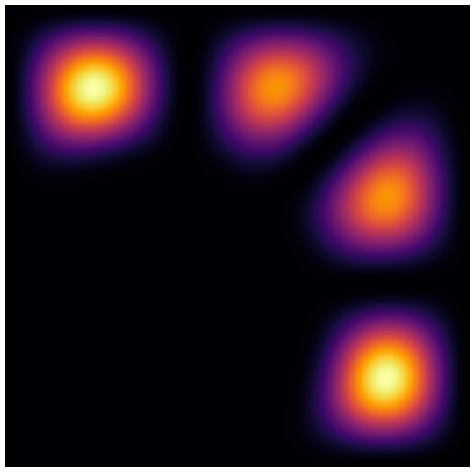

In [26]:
plt.figure(figsize=(6,6))
plt.pcolormesh(X, Y, get_e(3)**2, cmap='inferno')
plt.axis('off')
plt.show()